In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path += ["../src"]
import simulator_BC as sim_bc
from calibrator_blackit import Calibrator #i just commented few lines of code to remove the output print
#from black_it.calibrator import Calibrator
import pandas as pd
from black_it.samplers.halton import HaltonSampler
from msm_first_moments import MethodOfMomentsLoss_4Moments, MethodOfMomentsLoss_9Moments
from typing import Sequence
import os
import contextlib
from scipy.special import expit
import torch
from importlib import reload
from tqdm import tqdm
from time import time
from torch.distributions.beta import Beta
from torch.distributions.bernoulli import Bernoulli
from scipy.special import expit as sigmoid
import simulator_BC_coo as sim_coo

In [7]:
class BC_simulator_X_evidences_hidden_mu():
    def __init__(self, N, edges, evidences, real_epsilon, sum_ab = 1, rho = 70, seed = 1, dist = "beta"):
        T, edge_per_t, _ = edges.shape
        self.T = T
        self.edge_per_t = edge_per_t
        self.N = N
        self.dist = dist
        self.evidences = evidences
        self.edges = edges.clone().long()
        self.sum_ab = sum_ab
        self.real_epsilon = real_epsilon
        self.rho = rho
        self.seed = seed
        #self.mean_s = np.atleast_2d(edges[:,:,2].sum(dim = 1) / edge_per_t).T
        self.real_ts = np.atleast_2d([(torch.mean(evidences[t][1]).item(),
                                       torch.var(evidences[t][1]).item(),
                                       edges[t,:,2].sum() / edge_per_t) for t in range(T)])
    
    def simulate_mean_s_and_evidences_moments(self, theta, N = 200, seed = None):
        epsilon, mu = theta
        
        mean_ev_pred, var_ev_pred, mean_s_pred = [], [], []
        
        if seed != None:
            np.random.seed(self.seed)
        
        X0, _, _ = sim_coo.intialize_simulator(None, self.N, [])
        X_t = X0.copy()
        diff_X = X0[:,None] - X0[None,:]
        
        for t in range(self.T):
            u,v,s_obs = self.edges[t].T
            
            s_pred = (np.random.random(self.edge_per_t) < sigmoid(self.rho * (epsilon - np.abs(diff_X[u,v])))) + 0.
            new_X_t, diff_X = sim_coo.opinion_update(diff_X, X_t, u, v, s_pred, self.N, mu)
            
            X_t = new_X_t.copy()
            
            u_evidences = self.evidences[t][0]
            
            if self.dist == "beta":
                a,b = self.sum_ab * (X_t[u_evidences]), self.sum_ab * (1 - (X_t[u_evidences]))
                evidences_t = Beta(torch.Tensor(a), torch.Tensor(b)).sample()
            if self.dist == "bernoulli":
                evidences_t = Bernoulli(torch.Tensor(X_t[u_evidences])).sample()
            mean_ev_pred.append(torch.mean(evidences_t).item())
            var_ev_pred.append(torch.var(evidences_t).item())
            
            mean_s_pred.append(s_pred.mean())
            
            X_t  = np.clip(X_t, 10e-5, 1 - 10e-5)
        
        return np.atleast_2d([mean_ev_pred, var_ev_pred, mean_s_pred]).T

def calibrate_epsilon_BC_X_evidences_hidden_mu(simulator, plot_loss = True, calibration_batches = 100, 
                                               sampler = HaltonSampler, loss = MethodOfMomentsLoss_4Moments(),
                                               batch_size = 1, compare_all_s = False,
                                               parameters_bounds = [[0., 0.], [0.5, 1.]], precisions = [0.0001, 0.01], 
                                               return_time = False, ensemble_size = 1):
                                                                         #compute the mean of the losses obtained repeating the simulation ensemble_size times
    
    t0 = time()
    model = simulator.simulate_mean_s_and_evidences_moments
    real_data = simulator.real_ts
    
    samplers = [sampler(batch_size)]


    BC_cal = Calibrator(real_data = real_data,
                        samplers = samplers,
                        loss_function = loss,
                        model = model,
                        parameters_bounds = parameters_bounds,
                        parameters_precision = precisions,
                        ensemble_size = ensemble_size,
                        saving_folder = None,
                        verbose = False,
                        n_jobs = 1#'initial_state'
                       )
    
    params, losses = BC_cal.calibrate(calibration_batches)
    epsilon_sim, mu_sim = params.T
    
    loss_df = pd.DataFrame({"epsilon": epsilon_sim, "mu": mu_sim, "loss": losses}).sort_values("loss")
    
    

    estimated_epsilon, estimated_mu, _ = loss_df.iloc[0]
    t1 = time()
    calibration = {"loss": loss_df, "estimated_epsilon": estimated_epsilon, "estimated_mu": estimated_mu}
    
    if return_time:
        calibration["time"] = t1-t0
    
    return calibration


In [8]:
N, T, edge_per_t = 100, 100, 1
epsilon, mu = 0.2, 0.2
evidences_per_t, sum_ab = 10, 1
calibration_batches = 100


X, edges, evidences = sim_coo.simulator_BC_np_coo(N, T, edge_per_t, epsilon, mu, with_evidences = True, 
                                                  sum_ab = sum_ab, evidences_per_t = evidences_per_t, rho = 70)

simulator = BC_simulator_X_evidences_hidden_mu(N, edges, evidences, epsilon, sum_ab, rho = 70)


calibrated_epsilon_mu = calibrate_epsilon_BC_X_evidences_hidden_mu(simulator, calibration_batches = calibration_batches,
                                                      loss = MethodOfMomentsLoss_9Moments(),
                                                      ensemble_size = 1, return_time = True)


<AxesSubplot:xlabel='mu', ylabel='loss'>

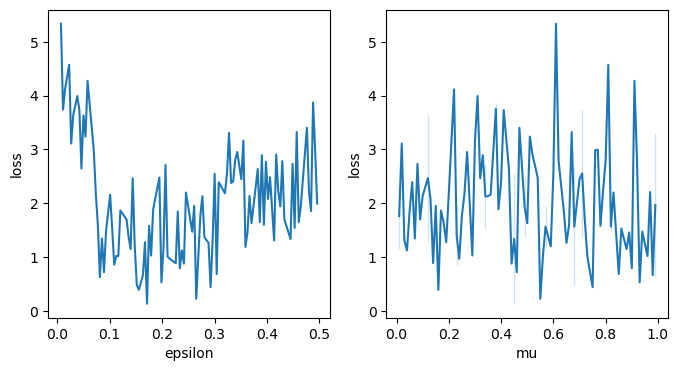

In [12]:
fig, axes = plt.subplots(ncols = 2, figsize = (8, 4))
sns.lineplot(data = calibrated_epsilon_mu["loss"], x = "epsilon", y = "loss", ax = axes[0])
sns.lineplot(data = calibrated_epsilon_mu["loss"], x = "mu", y = "loss", ax = axes[1])

### Repeated Simulations

In [30]:
def repeat_simulations_random(tot_simulations, T_list, N_list, edge_per_t_list, epsilon_list, mu_list,
                              ensemble_size_list, calibration_batches_list, sum_ab_list, evidences_per_t_list,
                              loss = MethodOfMomentsLoss_4Moments(),
                              verbose = True, dist = "beta"):
    
    simulations = []
    for _ in tqdm(range(tot_simulations), disable = not verbose):
        np.random.seed(_ + 40)
        T, N, edge_per_t, epsilon, mu, ensemble_size,\
        calibration_batches, sum_ab, evidences_per_t = np.random.choice(T_list), np.random.choice(N_list),\
        np.random.choice(edge_per_t_list), np.random.choice(epsilon_list), np.random.choice(mu_list),\
        np.random.choice(ensemble_size_list), np.random.choice(calibration_batches_list),\
        np.random.choice(sum_ab_list), np.random.choice(evidences_per_t_list)
        
        #X, edges, evidences = sim_bc_e.simulator_BC_evidence(N, T, edge_per_t, epsilon, mu, with_evidences = True, 
        #                                                     sum_ab = sum_ab, evidences_per_t = evidences_per_t, rho = 70)
        X, edges, evidences = sim_coo.simulator_BC_np_coo(N, T, edge_per_t, epsilon, mu, with_evidences = True, distribution_evidences = dist,
                                                          sum_ab = sum_ab, evidences_per_t = evidences_per_t, rho = 70)
        
        simulator = BC_simulator_X_evidences_hidden_mu(N, edges, evidences, epsilon, sum_ab, rho = 70, dist = dist)
        
        
        calibrated_epsilon_mu = calibrate_epsilon_BC_X_evidences_hidden_mu(simulator, 
                                                                           calibration_batches = calibration_batches,
                                                                           loss = loss,
                                                                           ensemble_size = ensemble_size, return_time = True, )

        
        _, epsilon_sim, mu_sim, time_sim = calibrated_epsilon_mu.values()

        
        simulations.append([epsilon_sim, np.abs(epsilon - epsilon_sim), mu_sim, np.abs(mu - mu_sim), 
                            sum_ab, evidences_per_t,\
                            time_sim, epsilon, mu, T, N, edge_per_t, ensemble_size,\
                            calibration_batches])
                    
    return pd.DataFrame(simulations, columns = ["epsilon", "distance_epsilon", "mu", "distance_mu", 
                                                "sum_ab", "evidences_per_t",
                                                "time", "real_epsilon", "real_mu", "T",
                                                "N", "edge_per_t", "ensemble_size",
                                                "calibration_batches"])

In [33]:
T_list = [100] 
N_list = [100]
edge_per_t_list = [1,4,8,16]
epsilon_list = np.arange(0.01, 0.49, 0.04) 
mu_list = np.arange(0.04, 0.99, 0.08)
ensemble_size_list = [1]
calibration_batches_list = [200]
evidences_per_t_list = [5,10,20,40]
sum_ab_list = [0.1, 1, 10]



calibrations_df_fixed = repeat_simulations_random(400, T_list, N_list, edge_per_t_list, epsilon_list, mu_list,
                                                  ensemble_size_list, calibration_batches_list,
                                                  sum_ab_list, evidences_per_t_list, 
                                                  verbose = True)


  1%|▌                                                                  | 3/400 [01:59<4:18:59, 39.14s/it]/home/jacopo.lenti/miniconda3/envs/learning-od-step-by-step/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
100%|█████████████████████████████████████████████████████████████████| 400/400 [4:30:58<00:00, 40.65s/it]


In [34]:
#calibrations_df_fixed.to_csv("../data/calibrations_evidences_hidden_mu_230620.csv")
calibrations_df_fixed = pd.read_csv("../data/calibrations_evidences_hidden_mu_230620.csv", index_col = 0)

In [29]:
calibrations_df_fixed.sort_values("distance_epsilon", ascending = False).head(10)

,epsilon,distance_epsilon,sum_ab,evidences_per_t,time,real_epsilon,real_mu,T,N,edge_per_t,ensemble_size,calibration_batches
312,0.0533,0.1967,0.1,40,33.310977,0.25,0.52,100,100,8,1,200
363,0.1015,0.1885,0.1,5,48.706229,0.29,0.04,100,100,8,1,200
210,0.2240,0.1860,1.0,10,25.895306,0.41,0.04,100,100,8,1,200
270,0.2275,0.1775,0.1,40,27.986487,0.05,0.68,100,100,8,1,200
66,0.2331,0.1769,1.0,40,29.782208,0.41,0.60,100,100,8,1,200
164,0.0358,0.1742,10.0,5,29.333850,0.21,0.44,100,100,4,1,200
19,0.4633,0.1733,1.0,10,31.006976,0.29,0.92,100,100,4,1,200
284,0.3427,0.1727,0.1,5,26.897986,0.17,0.92,100,100,4,1,200
202,0.1192,0.1708,10.0,40,27.449162,0.29,0.20,100,100,8,1,200
151,0.3007,0.1707,1.0,10,26.115332,0.13,0.52,100,100,4,1,200


In [30]:
calibrations_df_fixed.groupby("sum_ab").mean()[["time", "distance_epsilon"]]

,time,distance_epsilon
sum_ab,,
0.1,30.701365,0.047154
1.0,28.670989,0.054331
10.0,30.156123,0.049894


<AxesSubplot:ylabel='distance_epsilon'>

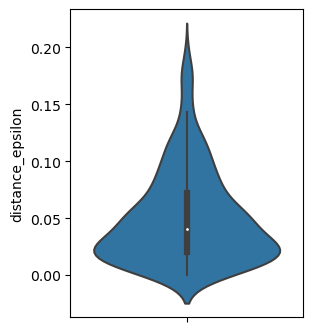

In [52]:
fig, axes = plt.subplots(figsize = (3, 4))
sns.violinplot(y = calibrations_df_fixed["distance_epsilon"])


In [55]:
calibrations_df_fixed.mean()[["distance_epsilon", "time"]]

distance_epsilon     0.050364
time                29.871338
dtype: float64

<AxesSubplot:ylabel='Density'>

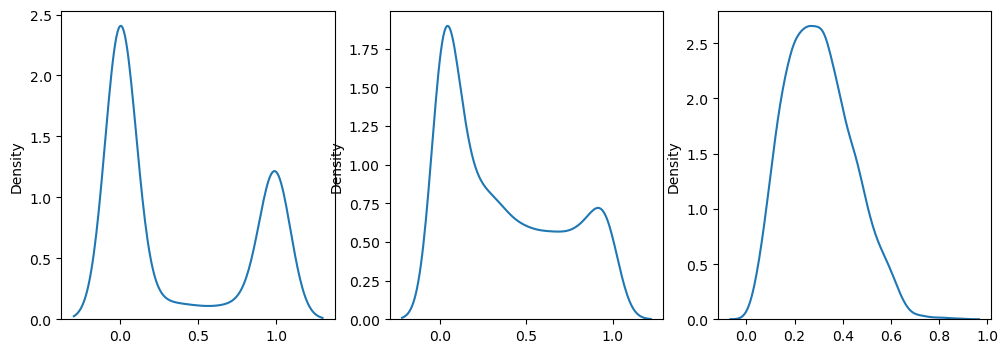

In [48]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))

sns.kdeplot(torch.distributions.beta.Beta(0.04,0.07).sample(sample_shape = [2000]), ax = axes[0])
sns.kdeplot(torch.distributions.beta.Beta(0.4,0.7).sample(sample_shape = [2000]), ax = axes[1])
sns.kdeplot(torch.distributions.beta.Beta(3,7).sample(sample_shape = [2000]), ax = axes[2])

<AxesSubplot:xlabel='sum_ab', ylabel='distance_epsilon'>

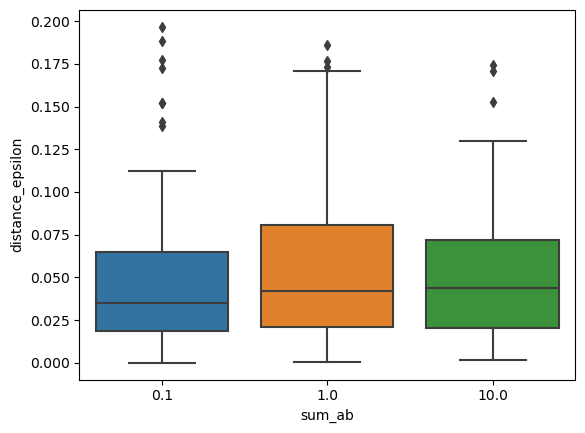

In [35]:
sns.boxplot(data = calibrations_df_fixed, x = "sum_ab", y = "distance_epsilon")

<AxesSubplot:xlabel='evidences_per_t', ylabel='distance_epsilon'>

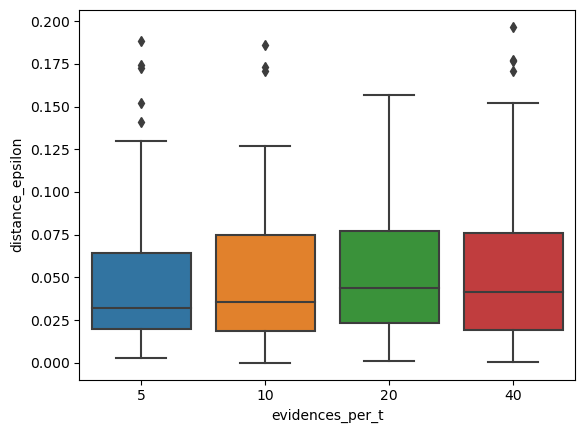

In [37]:
sns.boxplot(data = calibrations_df_fixed, x = "evidences_per_t", y = "distance_epsilon")

<AxesSubplot:xlabel='sum_ab', ylabel='evidences_per_t'>

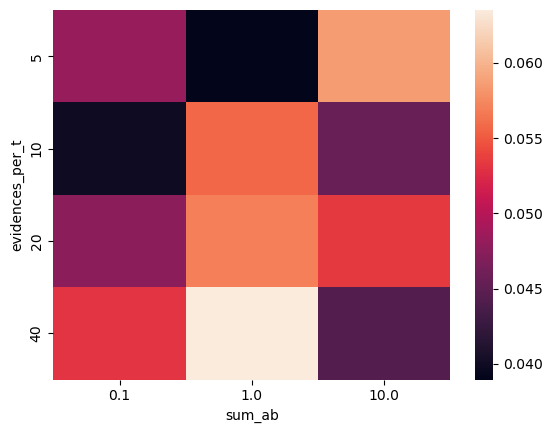

In [58]:
sns.heatmap(calibrations_df_fixed.groupby(["evidences_per_t", "sum_ab"]).mean()["distance_epsilon"].unstack())

<AxesSubplot:xlabel='real_mu', ylabel='distance_epsilon'>

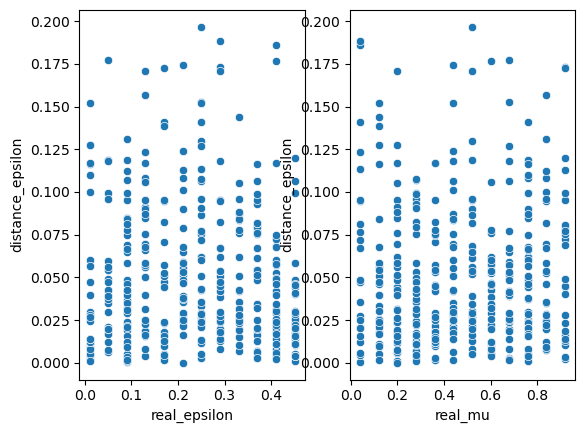

In [32]:
fig, axes = plt.subplots(ncols = 2)
sns.scatterplot(data = calibrations_df_fixed, x = "real_epsilon", y = "distance_epsilon", ax = axes[0])
sns.scatterplot(data = calibrations_df_fixed, x = "real_mu", y = "distance_epsilon", ax = axes[1])

<AxesSubplot:xlabel='edge_per_t', ylabel='distance_epsilon'>

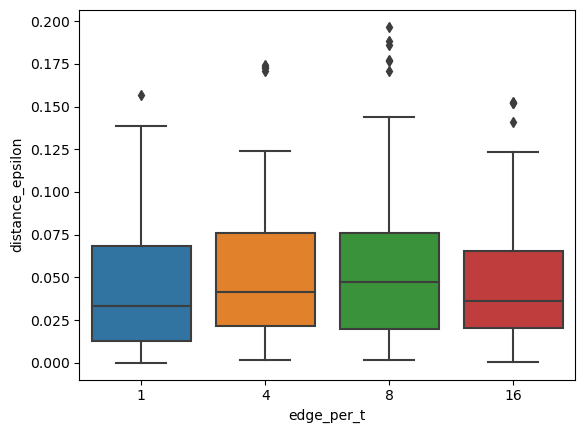

In [34]:
fig, axes = plt.subplots()

sns.boxplot(data = calibrations_df_fixed, x = "edge_per_t", y = "distance_epsilon", ax = axes)

In [59]:
calibrations_df_fixed.groupby("sum_ab").mean()

,epsilon,distance_epsilon,evidences_per_t,time,real_epsilon,real_mu,T,N,edge_per_t,ensemble_size,calibration_batches
sum_ab,,,,,,,,,,,
0.1,0.220944,0.047154,17.956204,30.701365,0.219051,0.508321,100.0,100.0,7.204380,1.0,200.0
1.0,0.251808,0.054331,19.330709,28.670989,0.242756,0.460787,100.0,100.0,6.637795,1.0,200.0
10.0,0.238559,0.049894,20.661765,30.156123,0.241176,0.457647,100.0,100.0,7.816176,1.0,200.0


## Bernoulli evidences

In [35]:
T_list = [100] 
N_list = [100]
edge_per_t_list = [1,4,8,16]
epsilon_list = np.arange(0.01, 0.49, 0.04) 
mu_list = np.arange(0.04, 0.99, 0.08)
ensemble_size_list = [1]
calibration_batches_list = [200]
evidences_per_t_list = [5,10,20,40]
sum_ab_list = [0.1, 1, 10]



calibrations_df_fixed = repeat_simulations_random(400, T_list, N_list, edge_per_t_list, epsilon_list, mu_list,
                                                  ensemble_size_list, calibration_batches_list,
                                                  sum_ab_list, evidences_per_t_list,dist = "bernoulli",
                                                  verbose = True)


  1%|▌                                                                  | 3/400 [01:44<3:53:00, 35.22s/it]/home/jacopo.lenti/miniconda3/envs/learning-od-step-by-step/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
100%|█████████████████████████████████████████████████████████████████| 400/400 [3:35:27<00:00, 32.32s/it]


In [36]:
#calibrations_df_fixed.to_csv("../data/calibrations_evidences_hidden_mu_bernoulli_230620.csv")
calibrations_df_fixed = pd.read_csv("../data/calibrations_evidences_hidden_mu_bernoulli_230620.csv", index_col = 0)

<AxesSubplot:ylabel='distance_mu'>

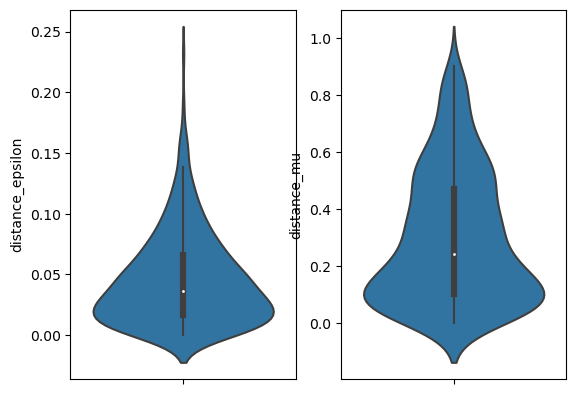

In [37]:
fig, axes = plt.subplots(ncols = 2)
sns.violinplot(y = calibrations_df_fixed["distance_epsilon"], ax = axes[0])
sns.violinplot(y = calibrations_df_fixed["distance_mu"], ax = axes[1])

In [40]:
calibrations_df_fixed.groupby("sum_ab").mean()

,epsilon,distance_epsilon,mu,distance_mu,evidences_per_t,time,real_epsilon,real_mu,T,N,edge_per_t,ensemble_size,calibration_batches
sum_ab,,,,,,,,,,,,,
0.1,0.226025,0.044250,0.514526,0.294380,17.956204,32.251475,0.219051,0.508321,100.0,100.0,7.204380,1.0,200.0
1.0,0.250379,0.040443,0.542441,0.300866,19.330709,31.599736,0.242756,0.460787,100.0,100.0,6.637795,1.0,200.0
10.0,0.255064,0.050655,0.507794,0.289265,20.661765,32.840782,0.241176,0.457647,100.0,100.0,7.816176,1.0,200.0
